### **Chargement des données:**

1. Upload Excel file "Historiques_cours_boursiers" directly to the Colab environment:

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Historiques_cours_boursiers.xlsx to Historiques_cours_boursiers.xlsx


2. Check if the file is present in the current directory:

In [ ]:
import os
os.listdir('.')

['.config', 'Historiques_cours_boursiers.xlsx', 'sample_data']

3. Importer le fichier:

In [ ]:
import pandas as pd

# Lire le fichier Excel
df = pd.read_excel("Historiques_cours_boursiers.xlsx")

In [ ]:
# Obtenir le nom des feuilles à partir du fichier Excel
excel_file = pd.ExcelFile("Historiques_cours_boursiers.xlsx")
sheet_names = excel_file.sheet_names

# Afficher le nom des feuilles
print(sheet_names)

['^IXIC', 'TTE', 'GE', 'RMS.PA', 'TSLA', 'JNJ', 'BRK-B', 'UNH', 'NVDA', 'MSFT', 'AAPL', 'GOOG', 'AMZN']


### **Examiner la performance historique de chaque cours:**

Cette étape est réalisée afin de choisir correctement les 6 indices boursiers à étudier:

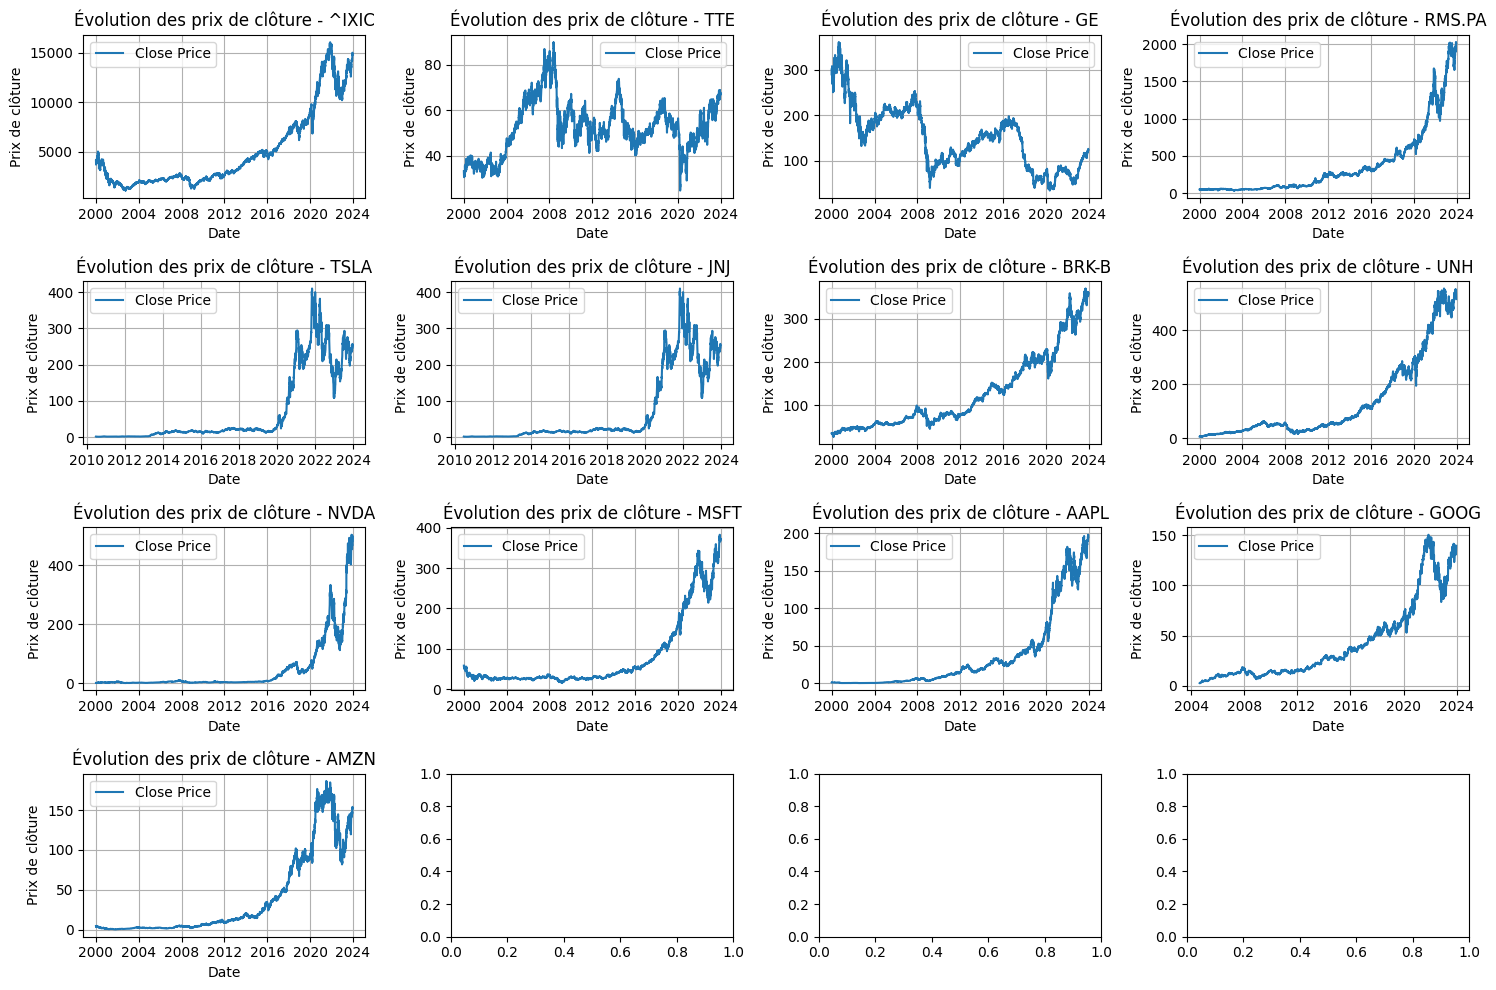

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier Excel
excel_file = pd.ExcelFile("Historiques_cours_boursiers.xlsx")

# Définir le nombre de lignes et de colonnes dans la grille
num_rows = 4
num_cols = 4

# Créer une figure avec une grille
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Aplatir la grille pour itérer à travers les sous-graphiques
axes = axes.flatten()

# Parcourir chaque feuille Excel
for i, sheet_name in enumerate(excel_file.sheet_names):
    # Charger les données de la feuille Excel
    df = excel_file.parse(sheet_name)

    # Créer le graphique d'évolution des prix de clôture
    axes[i].plot(df['Date'], df['Close'], label='Close Price')

    # Personnaliser le graphique
    axes[i].set_title(f'Évolution des prix de clôture - {sheet_name}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Prix de clôture')
    axes[i].legend()
    axes[i].grid(True)

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()

#### **Choix des 6 indices boursiers:**

1. En examinant les tendances historiques de chaque cours, on constate :

  - Des cours avec des tendances **volatiles** tels que : **TTE, GE, TSLA et JNJ**
    - Ces cours peuvent nous offrir des opportunités de rendements élevés en raison des fluctuations importantes des prix mais elles peuvent aussi subir des mouvements brusques à la hausse ou à la baisse =>  risque plus élevé.

  - Cours avec des tendances **plus stables** tels que : **GOOG, AAPL, UNH, RMS.PA, MSFT, AMZN, BRK-B et IXIC**
    - Ils réduisent le risque de pertes soudaines => moins de risques à court terme => horizon d'investissement à long terme

2. On note aussi une diversification dans des secteurs clés tels que la technologie, l'énergie, et le commerce en ligne.


In [ ]:
selected_tickers = ['TTE', 'GE', 'AAPL', 'GOOG', 'TSLA', 'UNH']

# Data frame du type {'GOOG': df_goog , 'AAPL' : df_aapl, ...}
df_tickers = {}

for ticker in selected_tickers:

    # Charger le df correspondant à chaque ticker
    df_ticker = excel_file.parse(ticker)
    df_tickers[ticker] = df_ticker

#print(df_tickers.keys())
#df_tickers['AAPL']


La selection choisie offre une combinaison judicieuse de tendances volatiles et stables, tout en assurant une représentation diversifiée dans des secteurs clés.

## **Variable à expliquer (Target):**

Elle est définie de la manière suivante à partir du prix de clôture (C):

In [ ]:
for ticker, df in df_tickers.items():
    # Créer une colonne 'Target' initialement à 'Stable' (1)
    df['Target'] = 1

    # Identifier les indices où la tendance est à la 'Hausse' (2)
    hausse_indices = df.index[(df['Close'].shift(-5) - df['Close'])/ df['Close'] * 100 > 2]
    df.loc[hausse_indices, 'Target'] = 2

    # Identifier les indices où la tendance est à la 'Baisse' (0)
    baisse_indices = df.index[(df['Close'].shift(-5) - df['Close'])/ df['Close'] * 100 < -2]
    df.loc[baisse_indices, 'Target'] = 0

#df_tickers['AAPL']

### Distribution de la variable Target:

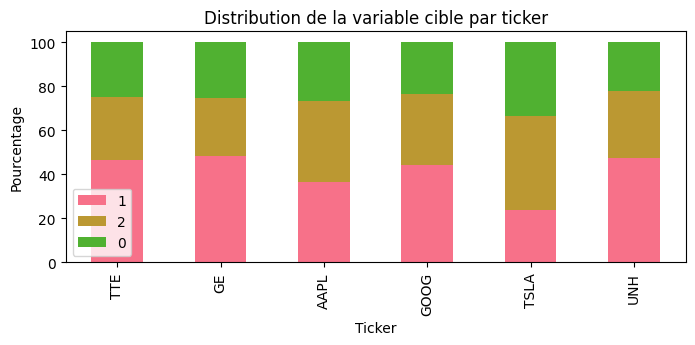

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_list = []

for ticker, df in df_tickers.items():
    counts = df['Target'].value_counts(normalize=True) * 100
    counts['Ticker'] = ticker
    df_list.append(counts)

# Concaténer les résultats en un seul DataFrame
df_combined = pd.concat(df_list, axis=1).T
df_combined = df_combined.fillna(0)

# Tracer le graphique à barres empilées
sns.set_palette("husl")  # Choisir une palette de couleurs
df_combined.set_index('Ticker').plot(kind='bar', stacked=True, figsize=(8, 3))

plt.xlabel('Ticker')
plt.ylabel('Pourcentage')
plt.title('Distribution de la variable cible par ticker')
plt.show()

**Interprétation du graphique** :

Le graphique représente la distribution de la variable Target pour les 6  tickers d'actions choisis.

La variable cible est représentée par trois catégories (mouvements de prix): 'Baisse': 0, 'Stable' : 1, et 'Hausse' : 2.

- Tous les tickers montrent un **déséquilibre** des classes avec la classe 'Stable' (1) étant la plus fréquente pour la majorité des tickers.

- Ce déséquilibre reflète la nature des marchés financiers, où les jours inhabituels sont généralement rares par rapport aux jours typiques.


## **Variables explicatives (features):**

### Matrice de corrélation des caractéristiques:

<ipython-input-9-843e56956f95>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


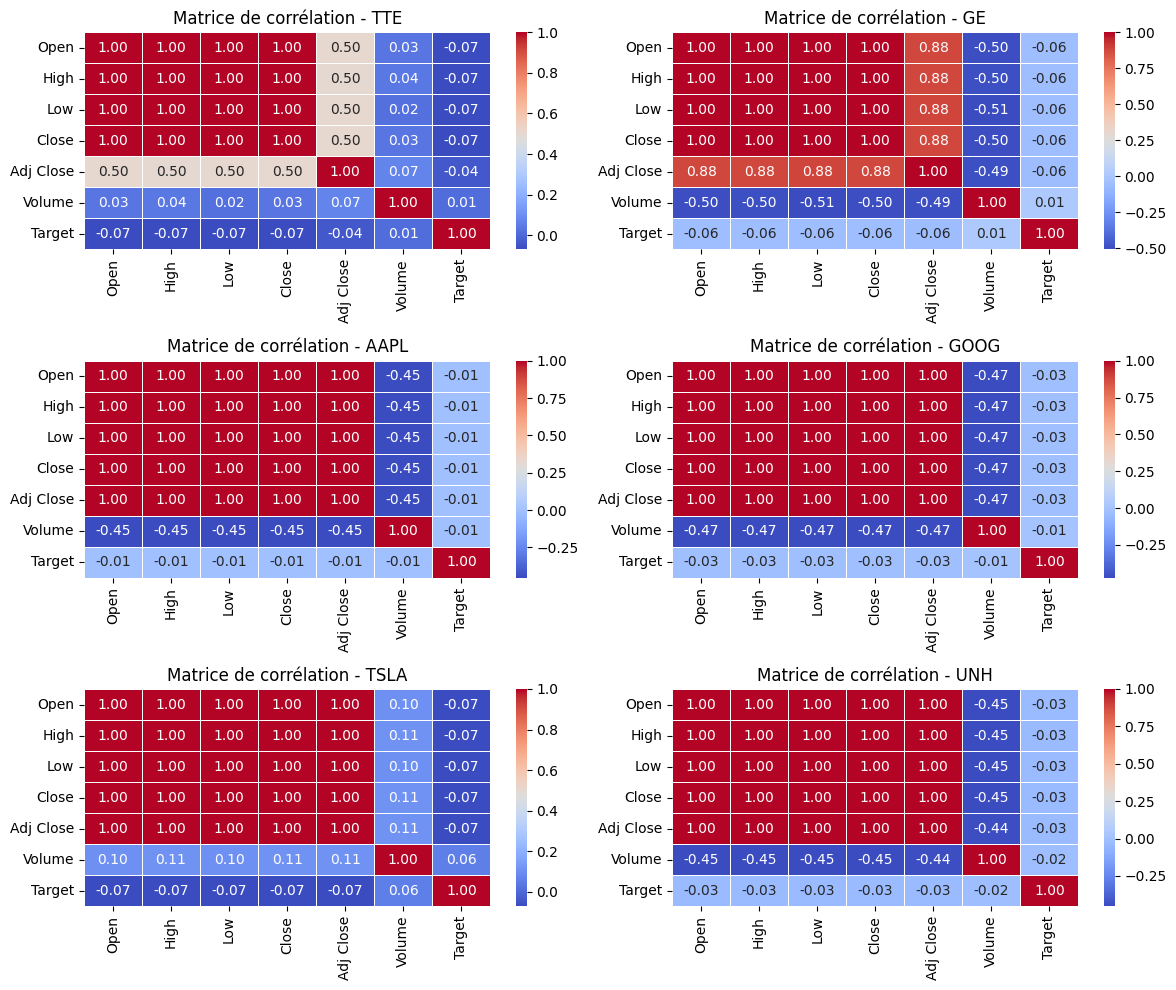

In [ ]:
num_rows = 3
num_cols = 2

# Ajuster la taille globale du graphique
plt.figure(figsize=(12, 10))

# Parcourir chaque DataFrame dans df_tickers
for i, (ticker, df) in enumerate(df_tickers.items(), 1):
    # Calculer la matrice de corrélation
    correlation_matrix = df.corr()

    # Tracer la heatmap de la matrice de corrélation
    plt.subplot(num_rows, num_cols, i)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Matrice de corrélation - {ticker}')

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()
plt.show()

#### **Analyse et Interprétation des résultas**:

- On constate de fortes corrélations entre **Open, High, Low et Close** => Cela suggère qu'utiliser toutes ces caractéristiques pourrait ne pas apporter beaucoup d'information supplémentaire pour le modèle => Utiliser uniquement Close ou bien introduire d'autres features (indicateurs).

- On constate une très faible corrélation entre Target et les variables explicatives => Cela suppose que des indicateurs techniques (MACD, RSI, etc.) pourraient être nécessaires pour mieux capturer les tendances.



### Moyenne exponentielle (EMA)

- Il s'agit d'un indicateur simple qui permet de suivre l'évolution du cours d'un titre dans le temps.

- L'EMA accorde plus de poids aux données les plus récentes, ce qui permet de réagir plus rapidement aux changements de prix. Cela en fait un indicateur utile pour suivre les tendances récentes du marché.

In [ ]:
import pandas as pd

# Fonction pour calculer la moyenne mobile exponentielle (EMA)
def EMA(data, column, period):

    alpha = 2 / (period + 1)
    ema = []

    for i in range(len(data)):
        if i == 0:
            # Pour la première ligne, l'EMA est égale à la valeur de la colonne
            ema.append(data[column][i])
        else:
            # Calcul de l'EMA en utilisant la formule de moyenne pondérée
            ema_t = alpha * data[column][i] + (1 - alpha) * ema[i-1]
            ema.append(ema_t)

    return ema

A partir de l’EMA, on peut construire les indicateurs de trading suivants :

### 1. **Calcul des indicateurs MACD** :

  
* **Ligne MACD** :

  - La ligne MACD est calculée en soustrayant la moyenne mobile exponentielle (EMA) de 26 jours de l'EMA de 12 jours. Elle capture la tendance à court terme par rapport à la tendance à long terme.

* **Signal MACD** :

  - La ligne de signal est une moyenne mobile exponentielle à 9 jours de la ligne MACD. Elle sert à identifier les points de retournement potentiel du marché.

* On cherche les croisements entre ces deux lignes pour identifier les signaux d'achat ou de vente potentiels:
  - Croisement haussier : Lorsque la ligne MACD croise au-dessus de la ligne de signal, cela peut être interprété comme un signal d'achat.
  - Croisement baissier : Lorsque la ligne MACD croise en dessous de la ligne de signal, cela peut être interprété comme un signal de vente.

* **Histogramme** :

   - L'histogramme est obtenu en soustrayant la ligne de signal de la ligne MACD.
   - Si l'histogramme est au-dessus de 0, cela indique une tendance haussière, et s'il est en dessous de 0, une tendance baissière.

In [ ]:
# Parcourir chaque dataframe dans le dictionnaire df_tickers
for ticker, df in df_tickers.items():

  # Calculer l'EMA (Moyenne Mobile Exponentielle) avec une période de 12 et 26
  df['EMA_12'] = EMA(df, 'Close', period=12)
  df['EMA_26'] = EMA(df, 'Close', period=26)

  # Calculer la ligne MACD = EMA12 - EMA26
  df['MACD'] = df['EMA_12'] - df['EMA_26']

  # Calculer le signal MACD en utilisant l'EMA du MACD avec une période de 9
  df['Signal'] = EMA(df,'MACD', 9)

  # Calculer l'histogramme du MACD en soustrayant le signal du MACD
  df['Histogram'] = df['MACD'] - df['Signal']

#df_tickers['AAPL'][['Date','MACD', 'Signal', 'Histogram','Target']]

Dans la pratique, les praticiens utilisent l’une des deux règles suivantes pour anticiper les hausses oules baisses de tendance à partir du MACD:

- Variation haussière si la ligne **MACD est positive** ou si **l’histogramme est positif.**
- Variation à la baisse si la ligne **MACD est négative** ou si **l’histogramme est négatif.**

In [ ]:
for ticker, df in df_tickers.items():

  # Créer une colonne pour les signaux de trading basés sur MACD
  df['Signal_MACD'] = 1  # pas de signal

  # MACD > 0 ou Histogram > 0 (Hausse)
  df.loc[(df['MACD'] > 0) | (df['Histogram'] > 0), 'Signal_MACD'] = 2

  # MACD < 0 ou Histogram < 0 (Baisse)
  df.loc[(df['MACD'] < 0) | (df['Histogram'] < 0), 'Signal_MACD'] = 0

#df_tickers['AAPL'][['Date','MACD', 'Signal', 'Histogram', 'Signal_MACD','Target']]

#### **Apple** : Exemple MACD sur l'année 2023:

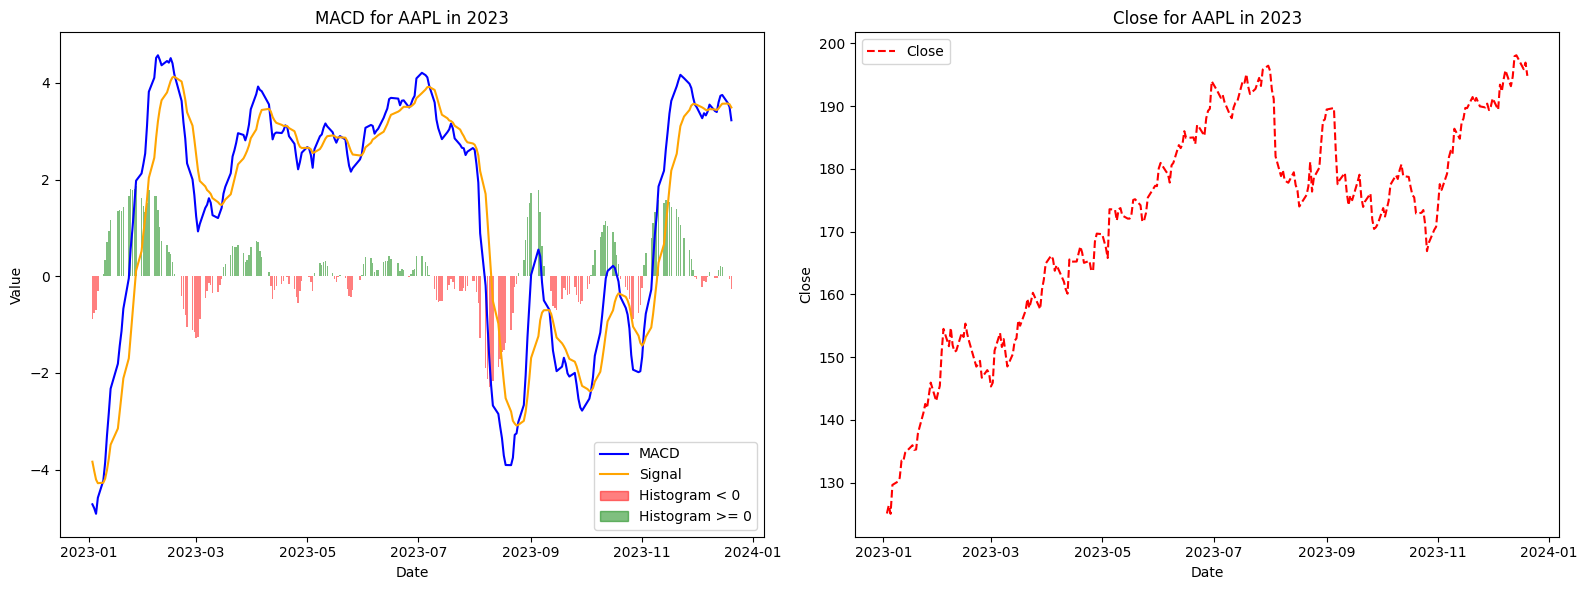

In [ ]:
import matplotlib.pyplot as plt

# Filtrer les données pour l'année 2023
df_aapl_2023 = df_tickers['AAPL'][(df_tickers['AAPL']['Date'] >= '2023-01-01') & (df_tickers['AAPL']['Date'] <= '2023-12-31')]
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Tracer le graphique MACD à gauche
axes[0].plot(df_aapl_2023['Date'], df_aapl_2023['MACD'], label='MACD', color='blue')
axes[0].plot(df_aapl_2023['Date'], df_aapl_2023['Signal'], label='Signal', color='orange')

hist_color = ['red' if h < 0 else 'green' for h in df_aapl_2023['Histogram']]
axes[0].bar(df_aapl_2023['Date'], df_aapl_2023['Histogram'], color=hist_color, alpha=0.5)

axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].set_title('MACD for AAPL in 2023')
axes[0].legend(handles=[
    plt.Line2D([0], [0], color='blue', label='MACD'),
    plt.Line2D([0], [0], color='orange', label='Signal'),
    plt.Rectangle((0, 0), 1, 1, color='red', alpha=0.5, label='Histogram < 0'),
    plt.Rectangle((0, 0), 1, 1, color='green', alpha=0.5, label='Histogram >= 0')
])

# Tracer le graphique 'Close' à droite
axes[1].plot(df_aapl_2023['Date'], df_aapl_2023['Close'], label='Close', color='red', linestyle='--')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Close')
axes[1].set_title('Close for AAPL in 2023')
axes[1].legend()

# Afficher les graphiques côte à côte
plt.tight_layout()
plt.show()


##### **Analyse des résultats**:

* Le graphique du prix de clôture montre une tendance générale à la hausse avec des périodes de recul.
* Les moments où la ligne MACD croise la ligne de signal correspondent à des points de retournement dans le graphique du prix de clôture.
  * Exemple 01 : Vers début mars 2023, la ligne MACD croise la ligne de signal à la hausse, ce qui coïncide avec une période où le prix de clôture commence à monter, indiquant une tendance haussière.
  * Exemple 02 : Vers mi-avril, on observe un croisement à la baisse de la ligne MACD en dessous de la ligne de signal, qui précède une baisse du prix de clôture, indiquant une tendance baissière.
* Les périodes où la ligne MACD est au-dessus de la ligne de signal pour une durée prolongée semblent alignées avec des périodes où le prix de l'action connaît une tendance haussière soutenue.
  * Exemple: Entre début janvier et fin février, la ligne MACD reste au-dessus de la ligne de signal pendant une période prolongée, ce qui correspond à une phase de hausse constante du prix de clôture.
* Cependant, il est également visible que le MACD peut produire des signaux retardés après que les changements de tendance se sont déjà produits dans le prix de l'action.
  * Exemple: Après le croisement à la baisse en mi-avril, le prix de clôture a déjà commencé à baisser avant le croisement, indiquant que le MACD peut effectivement fournir un signal retardé.

##### **Conclusion**:

L'indicateur MACD fournit des informations utiles sur la dynamique des prix. Mais, il convient de l'utiliser avec prudence et avec d'autres indicateurs pour prendre des décisions de trading éclairées.

### 2. **Calcul des indicateurs RSI** :

Le RSI (Relative Strength Index) est un indicateur qui mesure la puissance d’un mouvement boursier en période de hausse ou de baisse. Il est souvent utilisé par les pour détecter les signaux potentiels de surachat ou de survente.

Le RSI se base principalement sur deux composantes clés : les gains moyens et les pertes moyennes sur une période spécifiée, généralement 14 jours ou 21 jours.

Selon les valeurs de N, plusieurs règles empiriques sont proposées :
- si N = 21, la tendance du marché est à la **hausse** si **RSI > 50** et
à la **baisse** si **RSI < 50.**
- si N = 14, la tendance du marché est à la **hausse** si **RSI > 70** et à la baisse si **RSI < 30.**

In [ ]:
import numpy as np

# Périodes N pour les deux cas
periods = {'N1': 14, 'N2': 21}

def RSI(df, n):
    # Calculer la différence entre les prix de clôture consécutifs
    delta = df['Close'].diff()

    # Calculer les mouvements à la hausse
    up_moves = (delta.where(delta > 0, 0)).rolling(n).mean()

    # Calculer les mouvements à la baisse
    down_moves = (-delta.where(delta < 0, 0)).rolling(n).mean()

    # Calculer RSI
    rs = up_moves / down_moves
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Appliquer la fonction à chaque dataframe pour les deux périodes
for ticker, df in df_tickers.items():
    for key, n in periods.items():
        df[f'rsi_{n}'] = RSI(df, n)

        # Bornes supérieure et inférieure du signal de trading RSI
        upper_bound = 70 if key == 'N1' else 50
        lower_bound = 30 if key == 'N1' else 50

        # Calculer les signaux d'achat et de vente en fonction des bornes supérieure et inférieure
        df[f'sell_{n}'] = np.where(df[f'rsi_{n}'] >= upper_bound, 1, 0)
        df[f'buy_{n}']  = np.where(df[f'rsi_{n}'] <= lower_bound, 1, 0)

# df_tickers['AAPL'][['Date','MACD', 'Signal', 'Histogram', 'Signal_MACD','rsi_14','rsi_21','Target']]

#### **Apple** : Exemple RSI sur une période de 14 jours (Année 2023):

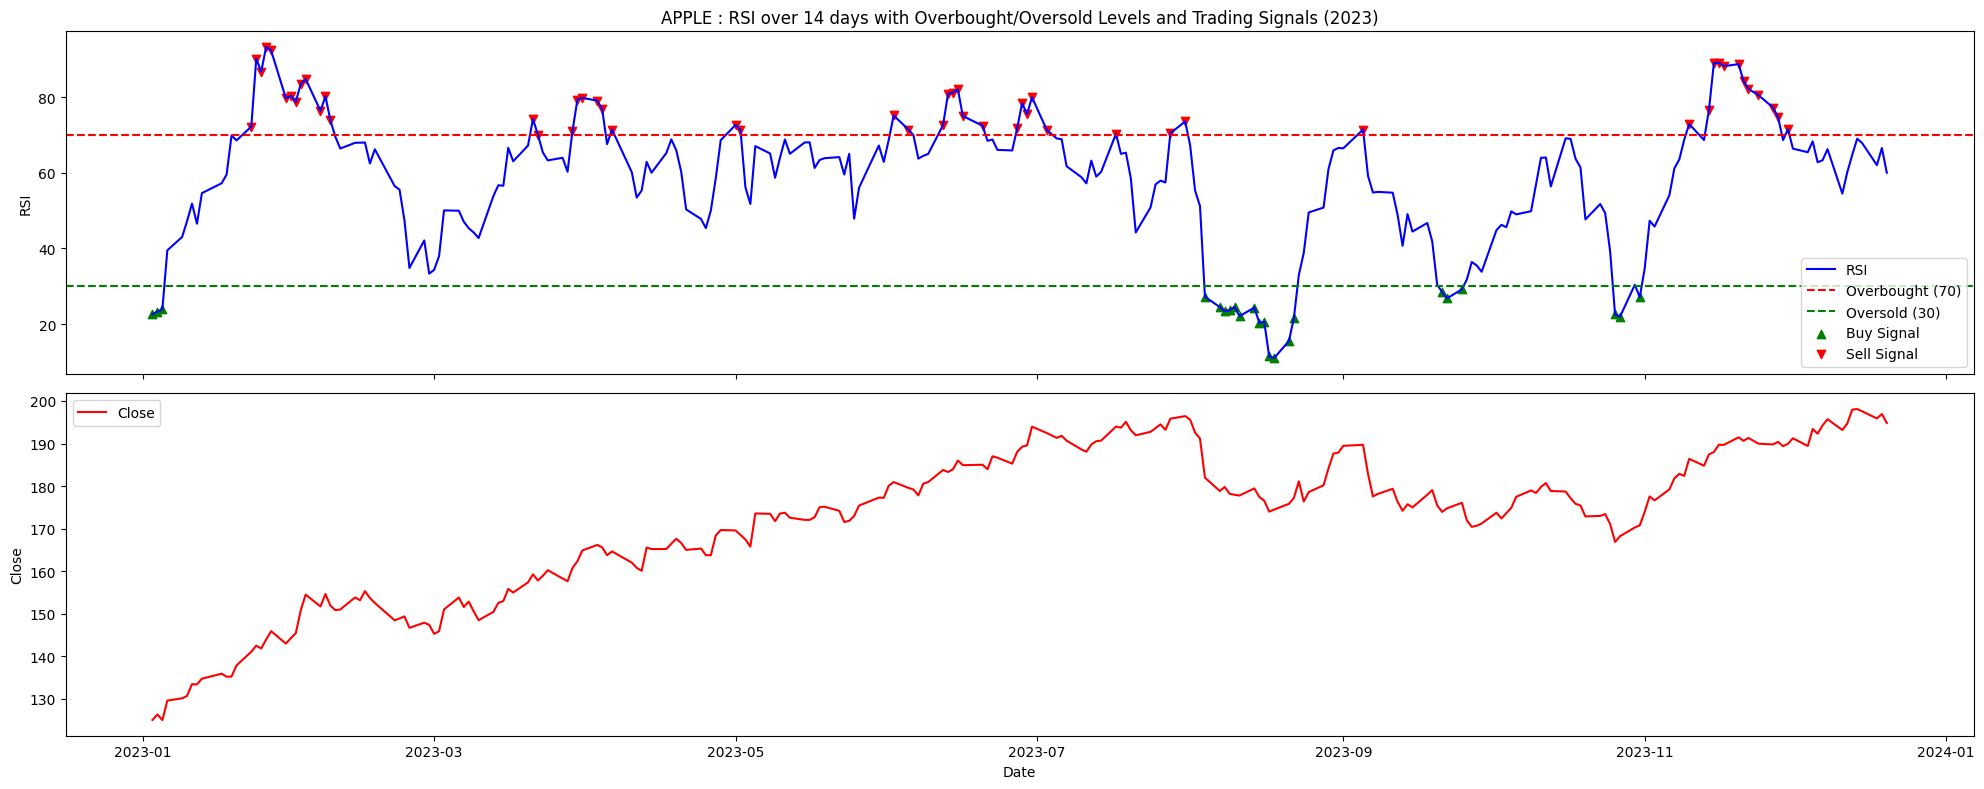

In [ ]:
import matplotlib.pyplot as plt

# Filtrer les données pour l'année 2023
df_2023 = df_tickers['AAPL'][(df_tickers['AAPL']['Date'] >= '2023-01-01') & (df_tickers['AAPL']['Date'] <= '2023-12-31')]

# Créer une nouvelle figure avec deux sous-graphiques empilés
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

# Tracer l'indice RSI dans le sous-graphique supérieur
ax1.plot(df_2023['Date'], df_2023['rsi_14'], label='RSI', color='blue')

# Tracer les lignes des niveaux de surachat et de survente
ax1.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
ax1.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')

# Ajouter des annotations pour les signaux d'achat et de vente
ax1.scatter(df_2023['Date'][df_2023['buy_14'] == 1], df_2023['rsi_14'][df_2023['buy_14'] == 1], marker='^', color='green', label='Buy Signal')
ax1.scatter(df_2023['Date'][df_2023['sell_14'] == 1], df_2023['rsi_14'][df_2023['sell_14'] == 1], marker='v', color='red', label='Sell Signal')

# Ajouter des légendes et un titre pour le sous-graphique supérieur
ax1.legend()
ax1.set_title('APPLE : RSI over 14 days with Overbought/Oversold Levels and Trading Signals (2023)')
ax1.set_ylabel('RSI')

# Tracer l'évolution des prix de clôture dans le sous-graphique inférieur
ax2.plot(df_2023['Date'], df_2023['Close'], label='Close', color='red')

# Ajouter une légende et un titre pour le sous-graphique inférieur
ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Close')

# Afficher le graphique
plt.tight_layout()
plt.show()



Analyses des résultats obtenue:

-  On constate que le RSI d'AAPL dépasse 70 à plusieurs reprises ce qui indique une zone de surachat. Cela veut dire que le prix a augmenté de manière significative et qu'il pourrait y avoir une correction à la baisse à venir.
  - Exemple : Sur la période autour de début mai, le RSI dépasse 70, indiquant une zone de surachat. Peu de temps après, le prix de clôture de l'action commence à baisser.

- De la meme manière, lorsque le RSI est inférieur à 30, cela indique que l'actif est survendu.

- Cependant, on peut constater que même si le RSI reste entre 30 et 70 pendant une grande partie de l'année, il y a des périodes de volatilité significative dans le prix de l'action qui ne sont pas capturés par ces deux seuils de RSI.

Ainsi, RSI peut ne pas refléter des variations significatives du prix de l'action qui n'atteignent pas ces extrêmes.



#### **Apple** : Exemple RSI sur une période de 21 jours (Année 2023):

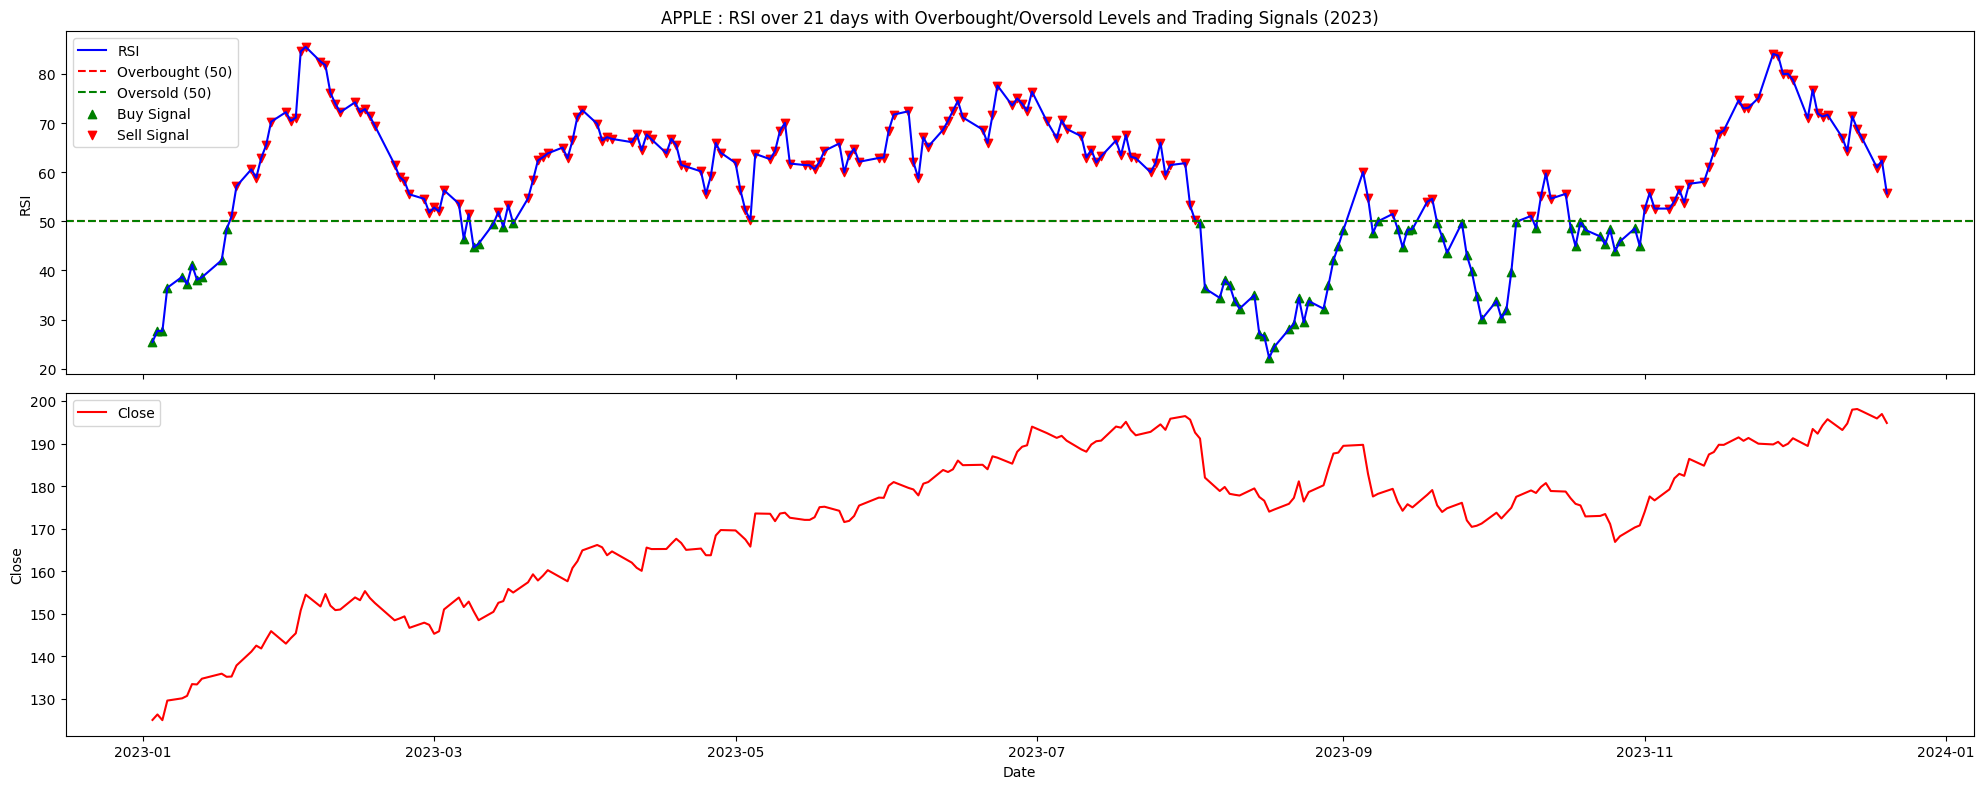

In [ ]:
import matplotlib.pyplot as plt

# Filtrer les données pour l'année 2023
df_2023 = df_tickers['AAPL'][(df_tickers['AAPL']['Date'] >= '2023-01-01') & (df_tickers['AAPL']['Date'] <= '2023-12-31')]

# Créer une nouvelle figure avec deux sous-graphiques empilés
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

# Tracer l'indice RSI dans le sous-graphique supérieur
ax1.plot(df_2023['Date'], df_2023['rsi_21'], label='RSI', color='blue')

# Tracer les lignes des niveaux de surachat et de survente
ax1.axhline(y=50, color='red', linestyle='--', label='Overbought (50)')
ax1.axhline(y=50, color='green', linestyle='--', label='Oversold (50)')

# Ajouter des annotations pour les signaux d'achat et de vente
ax1.scatter(df_2023['Date'][df_2023['buy_21'] == 1], df_2023['rsi_21'][df_2023['buy_21'] == 1], marker='^', color='green', label='Buy Signal')
ax1.scatter(df_2023['Date'][df_2023['sell_21'] == 1], df_2023['rsi_21'][df_2023['sell_21'] == 1], marker='v', color='red', label='Sell Signal')

# Ajouter des légendes et un titre pour le sous-graphique supérieur
ax1.legend()
ax1.set_title('APPLE : RSI over 21 days with Overbought/Oversold Levels and Trading Signals (2023)')
ax1.set_ylabel('RSI')

# Tracer l'évolution des prix de clôture dans le sous-graphique inférieur
ax2.plot(df_2023['Date'], df_2023['Close'], label='Close', color='red')

# Ajouter une légende et un titre pour le sous-graphique inférieur
ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Close')

# Afficher le graphique
plt.tight_layout()
plt.show()


Analyse des résultats obtenus:

En comparant le graphique du RSI 14 au RSI 21, on constate que le RSI 21 semble offrir une meilleure capacité à capturer les variations de prix à court terme, ce qui pourrait être plus approprié pour notre analyse.

### 3. **Calcul des indicateurs ATR** :

- L’ATR (Average True Range) est une mesure de la volatilité du marché.
  - Un ATR élevé démontre une forte intensité sur le marché.
  - Un ATR faible démontre une faible intensité sur le marché.
- L’indicateur dépend du nombre de périodes N. L’augmentation de N conduit à un meilleur lissage dela volatilité du cours boursier.

- Dans notre cas, N est fixé à 14 afin d'avoir un meilleur lissage de la volatilité des cours boursiers.

In [ ]:
for ticker, df in df_tickers.items():

  n = 14

  # Calculer les écarts
  df['TR'] = np.maximum.reduce([df['High'] - df['Low'], abs(df['High'] - df['Close']), abs(df['Low'] - df['Close'])])

  # Calculer l'Average True Range (ATR)
  ATR = df['TR'].rolling(window=n).mean()

  # Ajouter la colonne ATR à votre dataframe
  df['ATR'] = ATR

#df_tickers['AAPL'][['Date','MACD', 'Signal', 'Histogram', 'Signal_MACD','rsi_14','rsi_21','ATR','Target']]

#### **Apple** : ATR avec N=14

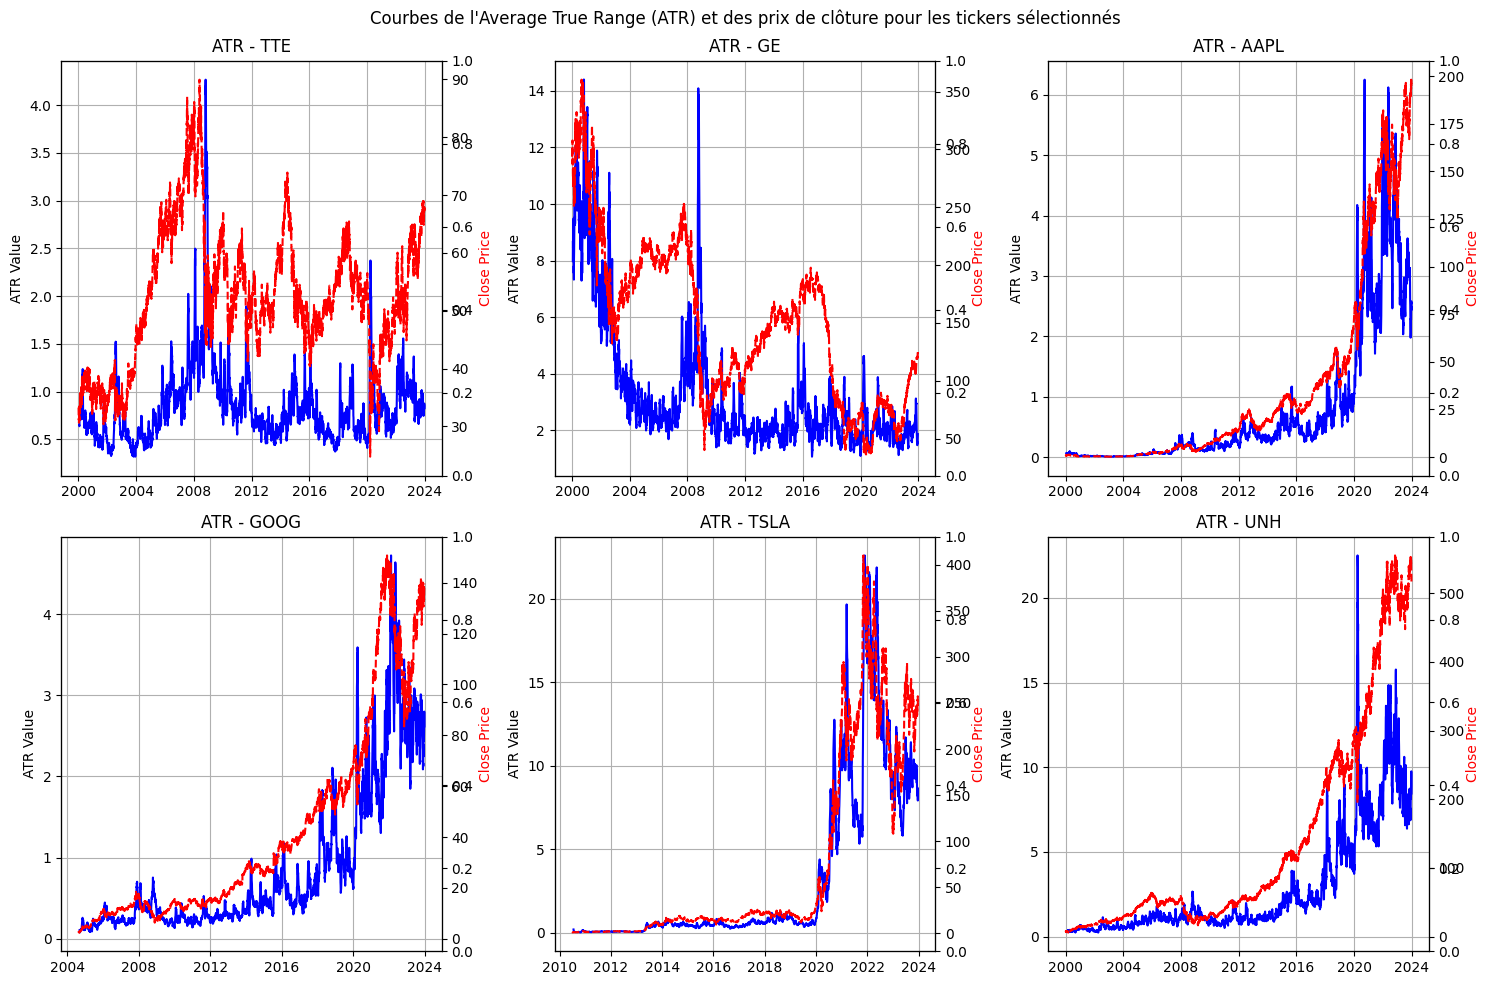

In [ ]:
import matplotlib.pyplot as plt

# Liste des tickers sélectionnés
selected_tickers = ['TTE', 'GE', 'AAPL', 'GOOG', 'TSLA', 'UNH']

# Créer une figure avec deux lignes et trois colonnes de sous-graphiques
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Aplatir la liste d'axes pour itérer plus facilement
axes = axes.flatten()

# Parcourir chaque ticker
for i, ticker in enumerate(selected_tickers):
    # Sélectionner le dataframe correspondant au ticker
    df = df_tickers[ticker]

    # Tracer la courbe ATR
    axes[i].plot(df['Date'], df['ATR'], label=f'ATR ({ticker})', color='blue')
    axes[i].set_title(f'ATR - {ticker}')
    axes[i].set_ylabel('ATR Value')
    axes[i].grid(True)

    # Tracer la courbe d'évolution des prix de clôture
    axes[i].twinx().plot(df['Date'], df['Close'], label=f'Close ({ticker})', color='red', linestyle='--')
    axes[i].twinx().set_ylabel('Close Price', color='red')

# Ajouter une légende et un titre commun
fig.suptitle('Courbes de l\'Average True Range (ATR) et des prix de clôture pour les tickers sélectionnés')
plt.xlabel('Date')

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()


Analyse des résultats obtenus :

- On constate une corrélation entre l'ATR et l'évolution des prix de clôture pour les différents tickers.

- Les pics de volatilité coïncident avec des périodes de mouvement significatif dans le prix de clôture, que ce soit à la hausse ou à la baisse.

Ainsi, l'indicateur ATR pourrait être un indicateur essentil pour notre analyse.


###   4.  **Indicateurs Volume de transactions** :



####  Chaikin Money Flow (CMF):

Il est fonction du prix le plus haut, du prix le plus bas, du prix de clôture et du volume de transactions.

Les professionnels recommandent de prendre N = 21 ou 28. L’interprétation est la suivante :
- Lorsque le CMF est supérieur à 0.25 (resp. inférieur à −0.25), le marché est à la hausse : le
prix de clôture et le volume de transactions augmentent ;
- lorsque le CMF est inférieur à −0, 25, il s’agit d’un signal baissier du marché ;
- Si le CMF est reste en dessous de zéro et que le prix de clôture monte, alors il y a un risque
de retournement de marché.

In [ ]:
import pandas as pd

# Périodes N pour les deux cas
periods = {'N1': 21, 'N2': 28}

def CMF(df, n):
    # Calcul de la différence entre les prix élevés et bas
    high_low_diff = df['High'] - df['Low']

    # Calcul de la différence entre les prix de clôture et bas
    close_low_diff = df['Close'] - df['Low']

    # Calcul de la différence entre les prix élevés et de clôture
    high_close_diff = df['High'] - df['Close']

    money_flow_multiplier = ((close_low_diff - high_close_diff) / high_low_diff) * df['Volume']

    cmf_numerator = money_flow_multiplier.rolling(window=n).sum()
    cmf_denominator = df['Volume'].rolling(window=n).sum()

    cmf = cmf_numerator / cmf_denominator

    # Ajout de la colonne CMF avec le nom de la période
    df[f'CMF_{n}'] = cmf
    return df

# Appliquer la fonction à chaque dataframe pour les deux périodes
for ticker, df in df_tickers.items():
    for key, n in periods.items():
        df = CMF(df, n)

df_tickers['AAPL'][['Date','MACD', 'Signal', 'Histogram', 'Signal_MACD','rsi_14','rsi_21','ATR','CMF_21','CMF_28','Target']]

,Date,MACD,Signal,Histogram,Signal_MACD,rsi_14,rsi_21,ATR,CMF_21,CMF_28,Target
0,2000-01-03,0.000000,0.000000,0.000000,1,NaN,NaN,NaN,NaN,NaN,0
1,2000-01-04,-0.006722,-0.001344,-0.005377,0,NaN,NaN,NaN,NaN,NaN,0
2,2000-01-05,-0.010843,-0.003244,-0.007599,0,NaN,NaN,NaN,NaN,NaN,0
3,2000-01-06,-0.020359,-0.006667,-0.013692,0,NaN,NaN,NaN,NaN,NaN,1
4,2000-01-07,-0.024377,-0.010209,-0.014168,0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
6026,2023-12-14,3.733616,3.524438,0.209178,2,68.983166,68.844898,2.565001,0.238431,0.278117,1
6027,2023-12-15,3.750712,3.569693,0.181019,2,67.844041,66.902397,2.538572,0.236463,0.212956,1
6028,2023-12-18,3.587345,3.573223,0.014122,2,62.002613,60.934151,2.578572,0.257391,0.197277,1
6029,2023-12-19,3.502231,3.559025,-0.056794,0,66.535588,62.376220,2.431429,0.285292,0.212203,1


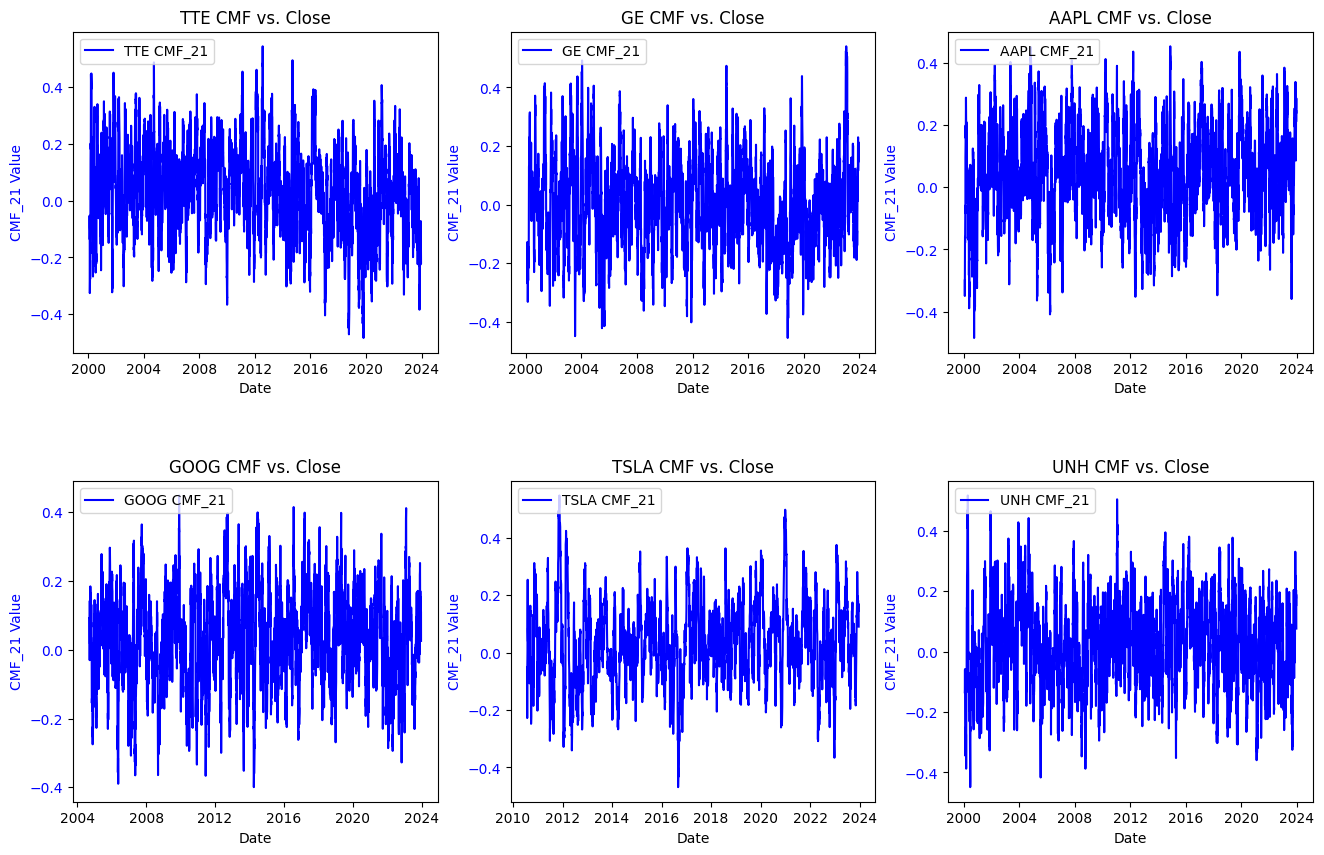

In [ ]:
import matplotlib.pyplot as plt

# Créer un subplot pour afficher les graphiques
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
fig.subplots_adjust(hspace=0.4)

for i, (ticker, df) in enumerate(df_tickers.items()):
    # Calculer la position dans le subplot
    row = i // 3
    col = i % 3

    # Créer un premier axe y (pour CMF)
    ax1 = axs[row, col]
    ax1.plot(df['Date'], df['CMF_21'], label=f'{ticker} CMF_21', color='b')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('CMF_21 Value', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc='upper left')


    ax1.set_title(f'{ticker} CMF vs. Close')

# Afficher les graphiques
plt.show()


Les graphiques montrent que le CMF fluctue fréquemment au-dessus et en dessous des seuils clés de 0.25 et -0.25, indiquant des périodes de pression d'achat et de vente.

Lorsque le CMF dépasse 0.25, il a tendance à continuer à augmenter, ce qui suggère une pression d'achat croissante sur le cours boursier. De manière inverse, lorsque le CMF dépasse -0.25, il a tendance à continuer à baisser, indiquant une pression de vente persistante sur le cours boursier.

Cet indicateur est donc particulièrement intéressant pour notre analyse des cours boursiers, car il nous fournit des informations cruciales sur les tendances à court terme du marché. Il nous permet de repérer les périodes où les investisseurs sont enclins à acheter ou à vendre.



###   5.  **Autres Indicateurs** :

#### **Bollinger Bands :**

- Les Bollinger Bands sont un indicateur technique utilisé pour mesurer la volatilité des prix.

- Ils se composent de trois lignes :
  - **bande supérieure**:  calculée en ajoutant deux fois l'écart type des prix de clôture à la moyenne mobile des prix de clôture sur une période donnée.

  - **bande inférieure**: calculée en soustrayant deux fois l'écart type des prix de clôture à la moyenne mobile des prix de clôture sur la même période.

  - **bande du milieu**: Il s'agit de la moyenne mobile des prix de clôture sur la même période que celle utilisée pour la bande supérieure.
  
Les prix qui touchent la bande supérieure sont considérés comme surachetés, tandis que ceux qui touchent la bande inférieure sont considérés comme survendus.

In [ ]:
def add_bollinger_bands(df, window=20):
    # Calcul de la moyenne mobile (bande du milieu)
    df['Middle_Band'] = df['Close'].rolling(window=window).mean()

    # Calcul de l'écart-type
    df['Std_Dev'] = df['Close'].rolling(window=window).std()

    # Calcul des bandes supérieure et inférieure
    df['Upper_Band'] = df['Middle_Band'] + (2 * df['Std_Dev'])
    df['Lower_Band'] = df['Middle_Band'] - (2 * df['Std_Dev'])

# Ajouter les Bollinger Bands à chaque DataFrame dans df_tickers
for ticker, df in df_tickers.items():
    add_bollinger_bands(df)


#### **Momentum :**

- Le momentum est un indicateur qui mesure la rapidité et la force d'un mouvement de prix d'un actif financier.

- Il compare le prix actuel à un prix précédent pour indiquer une tendance à la hausse ou à la baisse.

- Le momentum est utilisé pour identifier, confirmer des tendances, repérer des divergences, et détecter des niveaux de surachat ou de survente sur les marchés financiers.

In [ ]:
import pandas as pd

# Période pour le calcul du momentum
periode = 5

# Fonction pour calculer le momentum
def calculate_momentum(df):
    df['Momentum'] = df['Close'].diff(periode)
    return df

# Appliquer la fonction à chaque DataFrame dans df_tickers
for ticker, df in df_tickers.items():
    df_tickers[ticker] = calculate_momentum(df)

In [ ]:
df_tickers['AAPL'].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Target',
       'EMA_12', 'EMA_26', 'MACD', 'Signal', 'Histogram', 'Signal_MACD',
       'rsi_14', 'sell_14', 'buy_14', 'rsi_21', 'sell_21', 'buy_21', 'TR',
       'ATR', 'CMF_21', 'CMF_28', 'Middle_Band', 'Std_Dev', 'Upper_Band',
       'Lower_Band', 'Momentum'],
      dtype='object')

## **Modélisations chosies**:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, hamming_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import numpy as np

# Créez une liste de modèles
models = [
    ('LogisticRegression', LogisticRegression(max_iter = 1000, random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
    ('XGBoostClassifier', XGBClassifier(random_state=42)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('MLPClassifier', MLPClassifier(random_state=42)),
    ('GaussianNB', GaussianNB())
]

#### Selection des features pertinents:

Afin de sélectionner les caractéristiques pertinentes pour notre analyse, on utilise deux méthodes:

#### **Matrice de corrélation**:

- En calculant la matrice de corrélation entre les différentes caractéristiques et indicateurs calculés, on arrive à identifier facilement les caractéristiques fortement corrélées.
- Ces dernières sont ensuite examinées de plus près pour éviter la multi-collinéarité.

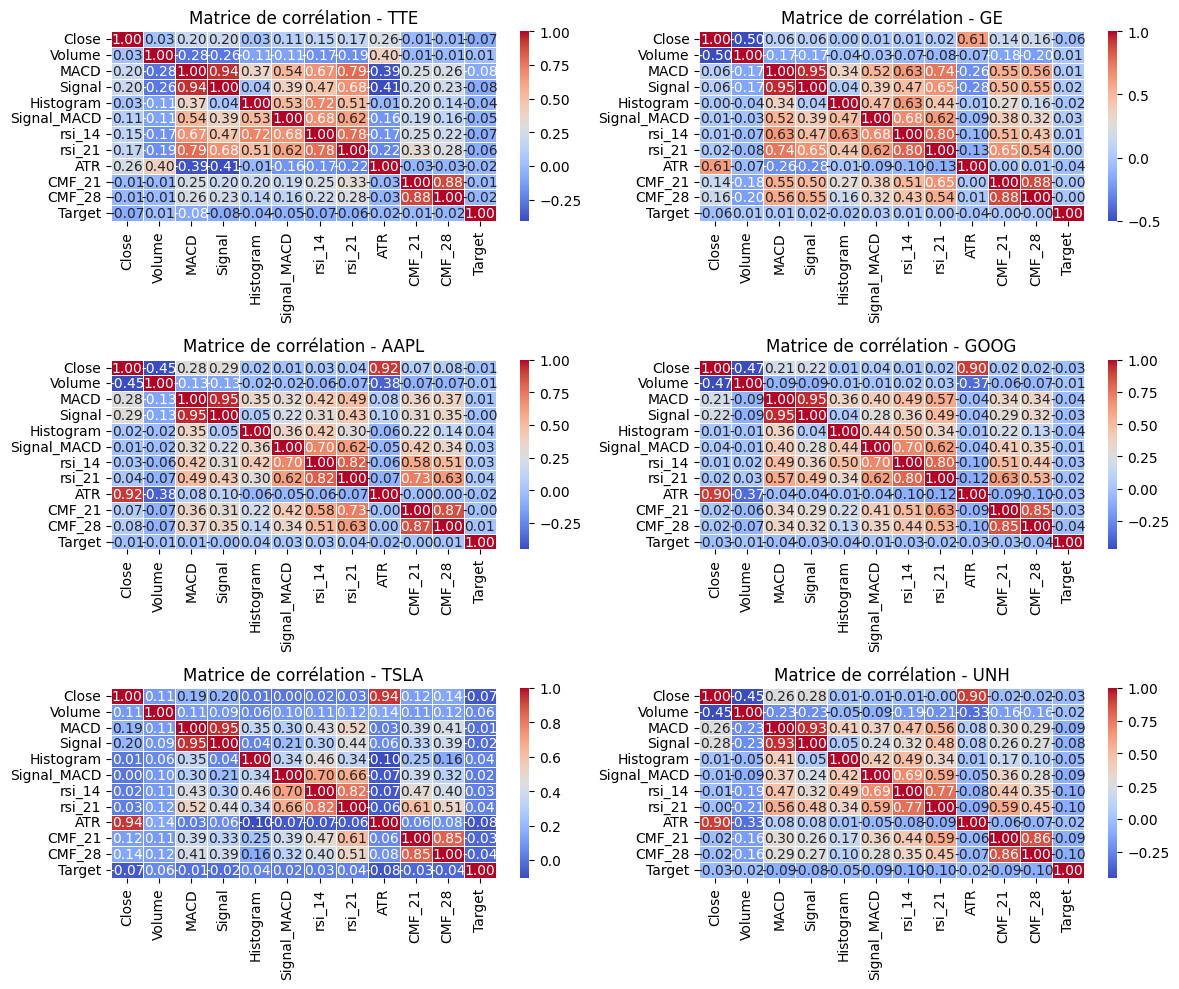

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Colonnes que vous souhaitez inclure dans la matrice de corrélation
selected_columns = ['Close', 'Volume', 'MACD', 'Signal','Histogram','Signal_MACD','rsi_14','rsi_21','ATR','CMF_21','CMF_28','Target']

num_rows = 3
num_cols = 2

# Ajuster la taille globale du graphique
plt.figure(figsize=(12, 10))

# Parcourir chaque DataFrame dans df_tickers
for i, (ticker, df) in enumerate(df_tickers.items(), 1):
    # Extraire uniquement les colonnes sélectionnées
    selected_df = df[selected_columns]

    # Calculer la matrice de corrélation
    correlation_matrix = selected_df.corr()

    # Tracer la heatmap de la matrice de corrélation
    plt.subplot(num_rows, num_cols, i)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Matrice de corrélation - {ticker}')

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionnez le DataFrame pour 'AAPL'
df_aapl = df_tickers['TTE']

# Colonnes que vous souhaitez inclure dans la matrice de corrélation
selected_columns = ['Close', 'Volume', 'MACD', 'Signal', 'Histogram', 'Signal_MACD', 'rsi_14', 'rsi_21', 'ATR', 'CMF_21', 'CMF_28', 'Target']

# Calculer la matrice de corrélation pour 'AAPL'
correlation_matrix = df_aapl[selected_columns].corr()

# Ajuster la taille globale du graphique
plt.figure(figsize=(10, 8))

# Tracer la heatmap de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de corrélation - TTE')
plt.show()


#### **Recursive Feature Elimination (RFE)**:

Afin d’affiner davantage la sélection de caractéristiques après avoir examiné la matrice de corrélation, on utilise une RFE pour s’assurer de la pertinence de la liste sélectionnée.

## **Entrainement des modèles**:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

# Créer une liste pour stocker les résultats de chaque modèle
results = []

for ticker, df in df_tickers.items():
    print(f"Cours boursier : {ticker}")
    print("-" * 50)
    df['Target'] = df['Target'].astype(float)
    df['Volume'] = df['Volume'].astype(float)

    # Traitement des valeurs NaN
    df = df.dropna()

    X = df.drop(['Target', 'Date', 'Low', 'High', 'Open'], axis=1)
    y = df['Target']

    # Normalisation des données avec StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model_names = []
    accuracies = []
    hamming_losses = []
    macro_precisions = []
    macro_recalls = []
    macro_fscores = []
    micro_precisions = []
    micro_recalls = []
    micro_fscores = []

    for model_name, model in models:
        model_names.append(model_name)

        if model_name not in ['LogisticRegression', 'SVM', 'KNeighborsClassifier', 'GradientBoostingClassifier', 'DecisionTreeClassifier', 'GaussianNB', 'MLPClassifier']:
            # Appliquer la RFE
            rfe = RFE(model, n_features_to_select=9)
            rfe.fit(X_train, y_train)
            X_train_rfe = rfe.transform(X_train)
            X_test_rfe = rfe.transform(X_test)
        else:
            X_train_rfe = X_train
            X_test_rfe = X_test

        # Entraîner le modèle
        model.fit(X_train_rfe, y_train)
        y_pred = model.predict(X_test_rfe)

        # Calculer l'accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        # Autres métriques
        hamming = hamming_loss(y_test, y_pred)
        hamming_losses.append(hamming)

        precision_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
        macro_precisions.append(precision_macro)
        macro_recalls.append(recall_macro)
        macro_fscores.append(fscore_macro)

        precision_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(y_test, y_pred, average='micro', zero_division=0)
        micro_precisions.append(precision_micro)
        micro_recalls.append(recall_micro)
        micro_fscores.append(fscore_micro)

        # Ajouter les résultats à la liste des résultats
        results.append([model_name, accuracy, hamming, precision_macro, recall_macro, fscore_macro, precision_micro, recall_micro, fscore_micro])

    # Créer un DataFrame avec les résultats
    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Hamming Loss', 'Macro Precision', 'Macro Recall', 'Macro F-Score', 'Micro Precision', 'Micro Recall', 'Micro F-Score'])

    results_df = results_df.round(2)

    # Afficher le DataFrame des résultats
    print(tabulate(results_df, headers='keys', tablefmt='pretty'))

    # Réinitialiser la liste des résultats pour le prochain ticker
    results = []


Cours boursier : TTE
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


+---+----------------------------+----------+--------------+-----------------+--------------+---------------+-----------------+--------------+---------------+
|   |           Model            | Accuracy | Hamming Loss | Macro Precision | Macro Recall | Macro F-Score | Micro Precision | Micro Recall | Micro F-Score |
+---+----------------------------+----------+--------------+-----------------+--------------+---------------+-----------------+--------------+---------------+
| 0 |     LogisticRegression     |   0.49   |     0.51     |      0.47       |     0.38     |     0.32      |      0.49       |     0.49     |     0.49      |
| 1 |            SVM             |   0.51   |     0.49     |      0.58       |     0.4      |     0.37      |      0.51       |     0.51     |     0.51      |
| 2 |   RandomForestClassifier   |   0.69   |     0.31     |       0.7       |     0.67     |     0.68      |      0.69       |     0.69     |     0.69      |
| 3 |     XGBoostClassifier      |   0.62   | 

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


+---+----------------------------+----------+--------------+-----------------+--------------+---------------+-----------------+--------------+---------------+
|   |           Model            | Accuracy | Hamming Loss | Macro Precision | Macro Recall | Macro F-Score | Micro Precision | Micro Recall | Micro F-Score |
+---+----------------------------+----------+--------------+-----------------+--------------+---------------+-----------------+--------------+---------------+
| 0 |     LogisticRegression     |   0.44   |     0.56     |      0.41       |     0.4      |     0.38      |      0.44       |     0.44     |     0.44      |
| 1 |            SVM             |   0.46   |     0.54     |      0.47       |     0.42     |     0.41      |      0.46       |     0.46     |     0.46      |
| 2 |   RandomForestClassifier   |   0.69   |     0.31     |      0.69       |     0.68     |     0.69      |      0.69       |     0.69     |     0.69      |
| 3 |     XGBoostClassifier      |   0.63   | 

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


+---+----------------------------+----------+--------------+-----------------+--------------+---------------+-----------------+--------------+---------------+
|   |           Model            | Accuracy | Hamming Loss | Macro Precision | Macro Recall | Macro F-Score | Micro Precision | Micro Recall | Micro F-Score |
+---+----------------------------+----------+--------------+-----------------+--------------+---------------+-----------------+--------------+---------------+
| 0 |     LogisticRegression     |   0.44   |     0.56     |      0.35       |     0.35     |     0.29      |      0.44       |     0.44     |     0.44      |
| 1 |            SVM             |   0.46   |     0.54     |      0.44       |     0.39     |     0.36      |      0.46       |     0.46     |     0.46      |
| 2 |   RandomForestClassifier   |   0.68   |     0.32     |      0.69       |     0.67     |     0.67      |      0.68       |     0.68     |     0.68      |
| 3 |     XGBoostClassifier      |   0.61   | 

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


+---+----------------------------+----------+--------------+-----------------+--------------+---------------+-----------------+--------------+---------------+
|   |           Model            | Accuracy | Hamming Loss | Macro Precision | Macro Recall | Macro F-Score | Micro Precision | Micro Recall | Micro F-Score |
+---+----------------------------+----------+--------------+-----------------+--------------+---------------+-----------------+--------------+---------------+
| 0 |     LogisticRegression     |   0.43   |     0.57     |      0.34       |     0.35     |     0.28      |      0.43       |     0.43     |     0.43      |
| 1 |            SVM             |   0.45   |     0.55     |      0.42       |     0.37     |      0.3      |      0.45       |     0.45     |     0.45      |
| 2 |   RandomForestClassifier   |   0.69   |     0.31     |      0.66       |     0.65     |     0.65      |      0.69       |     0.69     |     0.69      |
| 3 |     XGBoostClassifier      |   0.61   | 

### **Analyses et interprétations des résultats**: Voir le rapport



Essayons d'améliorer davantage les performances du Random Forest:

#### Optimisation des Hyperparamètres : Random Forest Classifier

In [ ]:

from sklearn.model_selection import GridSearchCV

df_test = df_tickers['AAPL']

df_test['Target'] = df_test['Target'].astype(float)
df_test['Volume'] = df_test['Volume'].astype(float)
df_test['Signal_MACD'] = df_test['Signal_MACD'].astype(float)

# Traitement des valeurs NaN
df_test = df_test.dropna()

X = df_test.drop(['Target', 'Date'], axis=1)
y = df_test['Target']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Hyperparamètres à tester pour RandomForest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=5,
                              n_jobs=-1,
                              verbose=2)

grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
print("Meilleurs paramètres pour RandomForest :")
print(grid_search_rf.best_params_)

best_rf_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = best_rf_model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)

# Afficher les résultats
print(f"\nRandom Forest après optimisation ===> Accuracy: {accuracy:.2f}")

Meilleurs paramètres pour RandomForest :
{'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest après optimisation ===> Accuracy: 0.70


J'ai tenté d'optimiser les hyper-paramètres du modèle Random Forest, étant donné qu'il avait affiché les performances les plus prometteuses lors de nos évaluations initiales. Cependant, malgré les efforts pour ajuster les paramètres tels que la profondeur de l'arbre, le nombre d'estimateurs, et d'autres, je n'ai pas réussi à obtenir une amélioration significative des résultats.

#### Bagging : Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

df_test = df_tickers['AAPL']

df_test['Target'] = df_test['Target'].astype(float)
df_test['Volume'] = df_test['Volume'].astype(float)
df_test['Signal_MACD'] = df_test['Signal_MACD'].astype(float)

# Traitement des valeurs NaN
df_test = df_test.dropna()

X = df_test.drop(['Target', 'Date'], axis=1)
y = df_test['Target']

# Bagging avec RandomForest
bagging_model = BaggingClassifier(
    base_estimator=RandomForestClassifier(random_state=42),
    n_estimators=10,
    random_state=42
)

bagging_model.fit(X_train, y_train)
bagging_accuracy = bagging_model.score(X_test, y_test)
print(f"Bagging (RandomForest) Accuracy: {bagging_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging (RandomForest) Accuracy: 0.65


#### Stacking :

Prendre plusieurs modèles différents et d'utiliser leurs prédictions comme entrée pour un modèle final qui fait la prédiction finale.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

df_test = df_tickers['AAPL']

df_test['Target'] = df_test['Target'].astype(float)
df_test['Volume'] = df_test['Volume'].astype(float)
df_test['Signal_MACD'] = df_test['Signal_MACD'].astype(float)

# Traitement des valeurs NaN
df_test = df_test.dropna()

X = df_test.drop(['Target', 'Date'], axis=1)
y = df_test['Target']

# Définir les modèles de base
base_models = [
    ('rf_model', RandomForestClassifier(random_state=42)),
    ('xgb_model', XGBClassifier(random_state=42)),
    ('svr_model', SVC(probability=True, random_state=42))
]

# Définir le modèle méta-learner
meta_model = LogisticRegression(random_state=42)

# Création du modèle de stacking
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

stacking_model.fit(X_train, y_train)
stacking_accuracy = stacking_model.score(X_test, y_test)
print(f"Stacking Accuracy: {stacking_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Accuracy: 0.69


De même, l'application des techniques de bagging et stacking, qui consistent à agréger les prédictions de plusieurs modèles pour réduire la variance, n'a pas eu l'impact escompté sur les différents modèles.